In [5]:
import numpy as np
import sklearn.ensemble as ens
import gdal
from osgeo import ogr, osr
import os
import subprocess
import gdal
from osgeo import ogr, osr
import numpy as np
import numpy.ma as ma
import tempfile
from tempfile import TemporaryDirectory
import sklearn.ensemble as ens
from sklearn.model_selection import cross_val_score
from skimage import morphology as morph
import scipy.sparse as sp
from sklearn.externals import joblib as sklearn_joblib
import shutil
import zipfile



In [19]:
def reshape_raster_for_ml(image_array):
    """Reshapes an array from gdal order [band, y, x] to scikit order [x*y, band]"""
    bands, y, x = image_array.shape
    image_array = np.transpose(image_array, (1, 2, 0))
    image_array = np.reshape(image_array, (x * y, bands))
    return image_array

In [18]:
def get_training_data(image_path, shape_path, attribute="CODE", shape_projection_id=4326):
    """Given an image and a shapefile with categories, return x and y suitable
    for feeding into random_forest.fit.
    Note: THIS WILL FAIL IF YOU HAVE ANY CLASSES NUMBERED '0'
    WRITE A TEST FOR THIS TOO; if this goes wrong, it'll go wrong quietly and in a way that'll cause the most issues
     further on down the line."""
    with TemporaryDirectory() as td:
        shape_projection = osr.SpatialReference()
        shape_projection.ImportFromEPSG(shape_projection_id)
        image = gdal.Open(image_path)
        image_gt = image.GetGeoTransform()
        x_res, y_res = image_gt[1], image_gt[5]
        ras_path = os.path.join(td, "poly_ras")
        ras_params = gdal.RasterizeOptions(
            noData=0,
            attribute=attribute,
            xRes=x_res,
            yRes=y_res,
            outputType=gdal.GDT_Int16,
            outputSRS=shape_projection
        )
        # This produces a rasterised geotiff that's right, but not perfectly aligned to pixels.
        # This can probably be fixed.
        gdal.Rasterize(ras_path, shape_path, options=ras_params)
        rasterised_shapefile = gdal.Open(ras_path)
        shape_array = rasterised_shapefile.GetVirtualMemArray()
        local_x, local_y = get_local_top_left(image, rasterised_shapefile)
        shape_sparse = sp.coo_matrix(shape_array)
        y, x, features = sp.find(shape_sparse)
        training_data = np.empty((len(features), image.RasterCount))
        image_array = image.GetVirtualMemArray()
        image_view = image_array[:,
                    local_y: local_y + rasterised_shapefile.RasterYSize,
                    local_x: local_x + rasterised_shapefile.RasterXSize
                    ]
        for index in range(len(features)):
            training_data[index, :] = image_view[:, y[index], x[index]]
    return training_data, features


def get_local_top_left(raster1, raster2):
    """Gets the top-left corner of raster1 in the array of raster 2; WRITE A TEST FOR THIS"""
    inner_gt = raster2.GetGeoTransform()
    return point_to_pixel_coordinates(raster1, [inner_gt[0], inner_gt[3]])


def point_to_pixel_coordinates(raster, point, oob_fail=False):
    """Returns a tuple (x_pixel, y_pixel) in a georaster raster corresponding to the point.
    Point can be an ogr point object, a wkt string or an x, y tuple or list. Assumes north-up non rotated.
    Will floor() decimal output"""
    # Equation is rearrangement of section on affinine geotransform in http://www.gdal.org/gdal_datamodel.html
    if isinstance(point, str):
        point = ogr.CreateGeometryFromWkt(point)
        x_geo = point.GetX()
        y_geo = point.GetY()
    if isinstance(point, list) or isinstance(point, tuple):  # There is a more pythonic way to do this
        x_geo = point[0]
        y_geo = point[1]
    if isinstance(point, ogr.Geometry):
        x_geo = point.GetX()
        y_geo = point.GetY()
    gt = raster.GetGeoTransform()
    x_pixel = int(np.floor((x_geo - floor_to_resolution(gt[0], gt[1]))/gt[1]))
    y_pixel = int(np.floor((y_geo - floor_to_resolution(gt[3], gt[5]*-1))/gt[5]))  # y resolution is -ve
    return x_pixel, y_pixel



def floor_to_resolution(input, resolution):
    """Returns input rounded DOWN to the nearest multiple of resolution."""
    return input - (input%resolution)

In [4]:
import gdal
from sklearn.ensemble import RandomForestClassifier
image = gdal.Open(http://localhost:8888/edit/Documents/gis/Agave/agavero_28022017_planet.tif)

SyntaxError: invalid syntax (<ipython-input-4-238b477259a2>, line 3)

In [20]:
image = gdal.Open("agavero_28022017_planet.tif")
image_array = image.GetVirtualMemArray()
features_to_classify = reshape_raster_for_ml(image_array)




In [6]:
features.max()

6299

In [6]:
model = ens.ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.55, min_samples_leaf=2,
min_samples_split=16, n_estimators=100, n_jobs=-1, class_weight='balanced')

In [8]:
shape_path = "rough_training_poly.shp"
image_path = "agavero_28022017_planet.tif"

training_data = get_training_data(image_path, shape_path, attribute="CLASE", shape_projection_id=4326)

In [10]:
import pickle
with open("training_data.pkl", "wb") as file:
    pickle.dump(training_data, file)

In [1]:
import pickle
with open("training_data.pkl", "rb") as file:
    training_data = pickle.load(file)

In [2]:
training_data
features, classes = training_data
features
classes
features.shape

(4757435, 4)

In [5]:
import pandas as pd
feature_dataframe = pd.DataFrame(features,)

NameError: name 'table' is not defined

In [7]:
model.fit(features[0:20000, :], classes[0:20000])

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features=0.55,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
np.unique(classes[0:20000])

array([ 1,  2,  4,  5,  8,  9, 10], dtype=int16)

In [22]:
out_chunks = []
for chunk in np.array_split(features_to_classify, 10):
    out_chunks.append(model.predict(chunk))

In [23]:
out_classes = np.concatenate(out_chunks)
out_classes

array([9, 9, 9, ..., 9, 9, 9], dtype=int16)

In [25]:
def reshape_ml_out_to_raster(classes, width, height):
    """Reshapes an output [x*y] to gdal order [y, x]"""
    # TODO: Test this.
    image_array = np.reshape(classes, (height, width))
    return image_array

out_image_array = reshape_ml_out_to_raster(out_classes, 9999, 9444)

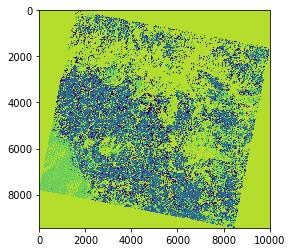

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(out_image_array)